<a href="https://www.kaggle.com/code/claricesatikoaoto/book-recomendation?scriptVersionId=133612981" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Sistema de recomendação de livros

A recomendação personalizada de produtos é um sistema que utiliza técnicas de ciência de dados e aprendizado de máquina para fornecer sugestões de produtos relevantes e adaptadas aos interesses e preferências de cada usuário. Em vez de apresentar apenas uma lista genérica de produtos, o sistema de recomendação personalizada busca entender as necessidades individuais dos usuários e oferecer recomendações que atendam a essas necessidades de maneira mais precisa.

O objetivo é criar uma experiência de compra mais personalizada, aumentar a satisfação do cliente e impulsionar as vendas. Para isso, o sistema de recomendação leva em consideração uma variedade de informações, como histórico de compras do usuário, avaliações e classificações de produtos, dados demográficos, preferências declaradas pelo usuário e comportamento de navegação no site.

A recomendação personalizada de produtos pode ser implementada em diferentes setores, como e-commerce, streaming de mídia, serviços de assinatura, entre outros, com o objetivo de fornecer sugestões relevantes e aumentar o engajamento e a fidelidade do usuário.

In [1]:
#Importando bibliotecas

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#para transformar em matriz
from scipy.sparse import csr_matrix

#Modelo preditivo
from sklearn.neighbors import NearestNeighbors


# Ignores warning messages 
import warnings
warnings.filterwarnings('ignore') 

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/book-recommendation-dataset/Ratings.csv
/kaggle/input/book-recommendation-dataset/Users.csv
/kaggle/input/book-recommendation-dataset/Books.csv
/kaggle/input/book-recommendation-dataset/recsys_taxonomy2.png


## O problema (fictício)

Nesta solução do problema iremos recomendar ao e-commerce sugestão de livros aos compradores baseada na avaliação recebida pelos leitores.

## Leitura dos dados

In [2]:
df_rating = pd.read_csv("/kaggle/input/book-recommendation-dataset/Ratings.csv")
df_users = pd.read_csv('/kaggle/input/book-recommendation-dataset/Users.csv')
df_books = pd.read_csv('/kaggle/input/book-recommendation-dataset/Books.csv',
                       usecols=['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher'])

## Conhecendo os dados

### df_books

A quantidade de valores nulos não vai alterar os dados. Trataremos este caso a frente. 

Não temos valores duplicados no dataset.

In [3]:
df_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
dtypes: object(5)
memory usage: 10.4+ MB


In [4]:
df_books.isna().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
dtype: int64

In [5]:
df_books.duplicated().sum()

0

In [6]:
df_books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


### df_users

O df_users refere-se às informações dos leitores contendo informações sobre a localidade e a idade. 
Não utilizaremos estas informações no desenvolvimento da solução do problema.

In [7]:
df_users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [8]:
#Utilizando a função split para separar a ciade, estado e o país
location = df_users['Location'].str.split(",", n=2, expand=True)
location.head()

,0,1,2
0,nyc,new york,usa
1,stockton,california,usa
2,moscow,yukon territory,russia
3,porto,v.n.gaia,portugal
4,farnborough,hants,united kingdom


In [9]:
#Atribuindo ao df_users as colunas cidade, estado, país em caixa alta e tirando os espaços em branco gerados pelo split.
df_users['City'] = location[0].str.upper().str.strip()
df_users['State'] = location[1].str.upper().str.strip()
df_users['Country'] = location[2].str.upper().str.strip()
df_users.drop(columns =["Location"], inplace = True)
df_users.head()

,User-ID,Age,City,State,Country
0,1,NaN,NYC,NEW YORK,USA
1,2,18.0,STOCKTON,CALIFORNIA,USA
2,3,NaN,MOSCOW,YUKON TERRITORY,RUSSIA
3,4,17.0,PORTO,V.N.GAIA,PORTUGAL
4,5,NaN,FARNBOROUGH,HANTS,UNITED KINGDOM


In [10]:
df_users.isna().sum()

User-ID         0
Age        110762
City            0
State           1
Country         2
dtype: int64

In [11]:
df_users.duplicated().sum()

0

<Axes: ylabel='Country'>

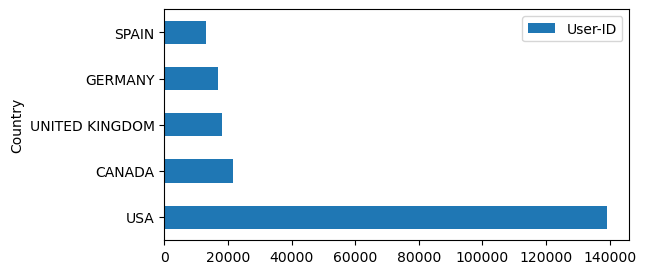

In [12]:
#Qual país tem mais avaliadores de livros?
(df_users
 .groupby('Country')['User-ID'].count()
 .reset_index()
 .sort_values(by='User-ID', ascending=False)[:5]
 .set_index('Country')
 .plot(kind='barh', figsize=(6,3))
)

In [13]:
#idade média cadastrada dos avaliadores dos livros
print(f'A idade média cadastrada dos avaliadores dos livros é de {round(df_users.Age.mean())} anos.')

american_age = round(df_users.query("Country == 'USA'")['Age'].mean())
print(f'A idade média dos americanos avaliadores com a idade cadastrada é {american_age} anos.')

A idade média cadastrada dos avaliadores dos livros é de 35 anos.
A idade média dos americanos avaliadores com a idade cadastrada é 38 anos.


### df_rating

Este são os dados da avaliação por usuario. Não temos valores nulos tampouco duplicados.

In [14]:
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [15]:
df_rating.isna().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [16]:
df_rating.duplicated().sum()

0

In [17]:
df_rating.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [18]:
avaliadores = df_rating['User-ID'].value_counts().shape[0]
maiores_avaliadores = df_rating['User-ID'].value_counts().sort_values(ascending=False)[:5].sum()

print(f'A base de dados conta com {avaliadores} avaliadores.')
print(f'Os cinco maiores avaliadores avaliaram {maiores_avaliadores} vezes.')

A base de dados conta com 105283 avaliadores.
Os cinco maiores avaliadores avaliaram 39002 vezes.


## Pré-processamento dos dados

In [19]:
#Unindo a base livros e notas pela coluna ISBN

df_books_rating = df_books.merge(df_rating, on='ISBN')
df_books_rating.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,2,0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,8,5
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,11400,0
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,11676,8
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,41385,0


In [20]:
#Lista dos dez primeiros livros  da base que obtiveram média de avaliação dez.
(
df_books_rating
.groupby('Book-Title')['Book-Rating'].mean()
.reset_index().sort_values(by='Book-Rating', ascending=False)
.query("`Book-Rating`==10.0")['Book-Title'][:10].to_list()
)

['Film Is: The International Free Cinema',
 'More Secrets of Happy Children: Embrace Your Power as a Parent--and Help Your Children be Confident, Positive, Well-Adjusted and Happy',
 "Jo's Boys : From the Original Publisher",
 'The Vanished Priestess : An Annie Szabo Mystery',
 'Game and Hunting',
 'Joan Miro: 1893-1983 (Basic Series)',
 "The Vampire's Apprentice",
 'The Vampire in Lore and Legend (Dover Books on Anthropology and Folklore)',
 'The Vampire in Literature: A Critical Bibliography (Studies in Speculative Fiction, No 21)',
 'Something Unpredictable: A Novel']

## Criando novas features

Verificando os livros com mais avaliações

In [21]:
#Verificando os livros com mais avaliaçoes
df_qde_avaliacao = (
    df_books_rating
    .groupby('Book-Title')['Book-Rating'].count()
    .reset_index()
    .sort_values(by='Book-Rating', 
                 ascending=False)
)

#Renomeando a coluna Book-rating para qtd-rating
df_qde_avaliacao.rename(columns={'Book-Rating': "Qtd-Rating"}, inplace=True)
df_qde_avaliacao.head()

,Book-Title,Qtd-Rating
234951,Wild Animus,2502
196326,The Lovely Bones: A Novel,1295
183573,The Da Vinci Code,898
5303,A Painted House,838
199237,The Nanny Diaries: A Novel,828


Média das notas recebidas por livro

In [22]:
#media das avaliaçoes
df_media_avaliacao = (
    df_books_rating
    .groupby('Book-Title')['Book-Rating'].mean()
    .reset_index()
    .sort_values(by='Book-Rating', 
                 ascending=False)
)

#Renomeando coluna
df_media_avaliacao.rename(columns={'Book-Rating': 'Mean-Rating'}, inplace=True)
df_media_avaliacao.head()

,Book-Title,Mean-Rating
66223,Film Is: The International Free Cinema,10.0
123125,More Secrets of Happy Children: Embrace Your P...,10.0
96558,Jo's Boys : From the Original Publisher,10.0
212107,The Vanished Priestess : An Annie Szabo Mystery,10.0
72503,Game and Hunting,10.0


juntando os dois datasets

In [23]:
#Unindo os dois datasets e filtrando os livros com mais de 200 avaliaçoes
df_feature = (
    df_qde_avaliacao
    .merge(df_media_avaliacao, on='Book-Title')
    .query("`Qtd-Rating` > 200")
)
df_feature.head()

,Book-Title,Qtd-Rating,Mean-Rating
0,Wild Animus,2502,1.019584
1,The Lovely Bones: A Novel,1295,4.468726
2,The Da Vinci Code,898,4.642539
3,A Painted House,838,3.231504
4,The Nanny Diaries: A Novel,828,3.530193


In [24]:
#Juntando as features criadas com a base de dados maior

df_final = df_books_rating.merge(df_feature, on='Book-Title')
df_final.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,Qtd-Rating,Mean-Rating
0,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,8,0,311,2.996785
1,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,11676,9,311,2.996785
2,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,29526,9,311,2.996785
3,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,36836,0,311,2.996785
4,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,46398,9,311,2.996785


In [25]:
df_final.duplicated().sum()

0

<Axes: xlabel='Book-Title'>

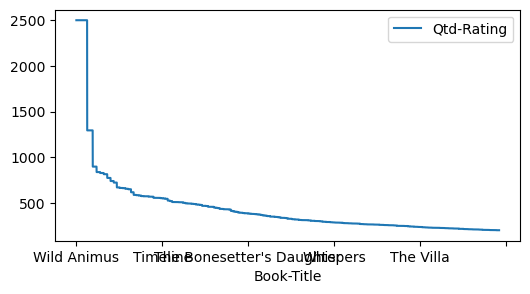

In [26]:
#Plot dos livros que obtiveram mais avaliaçõs
(df_final[['Book-Title', 'Qtd-Rating']]
 .set_index('Book-Title')
 .sort_values(by='Qtd-Rating', ascending=False)
 .plot(figsize=(6,3))
)

In [27]:
#Pivotando os dados para que o usuario seja a coluna, 
#as linhas sejam o livro e os valores, a avaliação dada por cada usuario
df_pivot = df_final.pivot_table(columns='User-ID', 
                                index='Book-Title', 
                                values='Book-Rating')
df_pivot.head()

User-ID,8,9,14,16,26,32,42,44,51,67,...,278800,278813,278824,278828,278832,278836,278843,278844,278846,278854
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1st to Die: A Novel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2nd Chance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A Bend in the Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A Case of Need,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
#Preenchendo os valores NaN por 0

df_pivot.fillna(0, inplace=True)
df_pivot.head()

User-ID,8,9,14,16,26,32,42,44,51,67,...,278800,278813,278824,278828,278832,278836,278843,278844,278846,278854
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Bend in the Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Case of Need,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
#Transformando o dataframe em matriz

df_sparce = csr_matrix(df_pivot)
df_sparce

<293x27719 sparse matrix of type '<class 'numpy.float64'>'
	with 42142 stored elements in Compressed Sparse Row format>

## Criando o modelo preditivo

O sistema utiliza algoritmos de filtragem colaborativa, filtragem baseada em conteúdo, ou uma combinação de ambos, para identificar padrões nos dados e fazer previsões sobre quais produtos são mais prováveis de serem apreciados pelo usuário. À medida que o usuário interage com o sistema e realiza mais compras, o modelo de recomendação é aprimorado e se torna mais preciso.

sklearn.neighborsfornece funcionalidade para métodos de aprendizado baseados em vizinhos não supervisionados e supervisionados. Os vizinhos mais próximos não supervisionados são a base de muitos outros métodos de aprendizado, principalmente o aprendizado múltiplo e o agrupamento espectral. 

As classes sklearn.neighborspodem lidar com arrays ou scipy.sparsematrizes NumPy como entrada. Para matrizes densas, um grande número de possíveis métricas de distância é suportado. Para matrizes esparsas, métricas arbitrárias de Minkowski são suportadas para pesquisas.

NearestNeighborsimplementa o aprendizado não supervisionado dos vizinhos mais próximos. Ele atua como uma interface uniforme para três algoritmos de vizinhos mais próximos diferentes: BallTree, KDTree, e um algoritmo de força bruta baseado em rotinas em sklearn.metrics.pairwise. A escolha do algoritmo de busca de vizinhos é controlada pela palavra-chave 'algorithm', que deve ser uma das . Quando o valor padrão é passado, o algoritmo tenta determinar a melhor abordagem a partir dos dados de treinamento. Para uma discussão sobre os pontos fortes e fracos de cada opção, consulte Algoritmos do vizinho mais próximo .['auto', 'ball_tree', 'kd_tree', 'brute']'auto'

Fonte: [Nearest Neighbors](https://scikit-learn.org/stable/modules/neighbors.html)

In [30]:
#Instanciando e treinando o modelo

model = NearestNeighbors(algorithm='brute')
model.fit(df_sparce)

NearestNeighbors(algorithm='brute')

## Novas predições

In [31]:
#1984
distances, suggestions = model.kneighbors(df_pivot.iloc[0, :].values.reshape(1, -1))

for i in range(len(suggestions)):
  print(df_pivot.index[suggestions[i]])

Index(['1984', 'Songs in Ordinary Time (Oprah's Book Club (Paperback))',
       'Slow Waltz in Cedar Bend', 'Saving Faith',
       'How Stella Got Her Groove Back'],
      dtype='object', name='Book-Title')


Como recomendaçao, o modelo preditivo recomendou ao leitor, os livros Songs in Ordinary Time, Slow Waltz in Cedar Bend, Saving Faith, How Stella got her groove back.

In [32]:
#A Bend in the Road
distances, suggestions = model.kneighbors(df_pivot.iloc[3, :].values.reshape(1, -1))

for i in range(len(suggestions)):
  print(df_pivot.index[suggestions[i]])

Index(['A Bend in the Road',
       'Songs in Ordinary Time (Oprah's Book Club (Paperback))',
       'Slow Waltz in Cedar Bend', 'Saving Faith',
       'How Stella Got Her Groove Back'],
      dtype='object', name='Book-Title')


In [33]:
#Ahe Rainmaker
distances, suggestions = model.kneighbors(df_pivot.iloc[238, :].values.reshape(1, -1))

for i in range(len(suggestions)):
  print(df_pivot.index[suggestions[i]])

Index(['The Rainmaker', 'Saving Faith', 'Slow Waltz in Cedar Bend',
       'Songs in Ordinary Time (Oprah's Book Club (Paperback))',
       'Ashes to Ashes'],
      dtype='object', name='Book-Title')
